# ***Bird Detection: Caltech-UCSD Birds 200 Dataset***

### ***`Code by @Om Mule`***

## Mount Google Drive for Dataset access through drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


#### The above cell will bring your own Google Drive to this Colab's runtime and then you can access the dataset stored in your drive from here 


## Import Libraries

In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import math
from tensorflow.keras.layers import Dense, Input, Flatten, GlobalAveragePooling2D
import tensorflow_datasets as tfds
import numpy as np

%matplotlib inline

In [3]:
# Data path 

data_dir = "/content/drive/MyDrive/TF3 C3 W1 Data/"

## Bounding Box Functions

- `draw_bounding_box_on_image`: Draws a single bounding box on an image.
- `draw_bounding_boxes_on_image`: Draws multiple bounding boxes on an image.
- `draw_bounding_boxes_on_image_array`: Draws multiple bounding boxes on an array of images.


In [4]:

# Function 1
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255,0,0), thickness = 5):
  image_width = image.shape[1]
  image_height = image.shape[0]
  # Draw a rectangle on the image using OpenCV
  cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)



# Function 2
def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):

  # Boxes: 2D numpy array of [N,4]: (ymin, xmin, ymax, xmax). Coordinates are normalized
  boxes_shape = boxes.shape
  if not boxes_shape:
    return 
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image,
                               boxes[i,1], boxes[i,0], boxes[i,3], boxes[i,2],
                               color[i], thickness)


# Function 3
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
  draw_bounding_boxes_on_image(image, boxes, color, thickness)
  return image

## Data Functions: Display the birds with bounding boxes

```
display_birds_with_boxes:``` Display images of birds along with bounding boxes that were drawn earlier

In [5]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_birds_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes) 

## Dataset Preprocessing Utilities/Functions

```1. read_image_tfds:``` 
1. Resize ```images``` to (224,224) 
2. Normalizes ```images```
3. Translates and Normalizes ```Bounding Boxes```

In [6]:
def read_image_tfds(image, bbox):
  image = tf.cast(image, tf.float32)
  shape = tf.shape(image)

  factor_x = tf.cast(shape[1], tf.float32)
  factor_y = tf.cast(shape[0], tf.float32)

  # Resize & Normalize the images
  image = tf.image.resize(image, size= (224,224,))
  image = image/127.5
  image -= 1

  bbox_list = [bbox[0]/factor_x,
               bbox[1]/factor_y,
               bbox[2]/factor_x,
               bbox[3]/factor_y]

  return image, bbox_list

``` 2. read_image_with_shape:```

Similar to ```read_image_tfds``` but keeps copy of ```original image``` & returns that as well

In [7]:
def read_image_with_shape(image, bbox):
  original_image = image
  image, bbox_list = read_image_tfds(image, bbox)

  return original_image, image, bbox_list

`3. read_image_tfds_with_original_bbox:`
1. Reads `image` from data
2. `Denormalizes` the bounding boxes

In [8]:
def read_image_tfds_with_original_bbox(data):
  image = data["image"]
  bbox = data["bbox"]

  shape = tf.shape(image)
  factor_x = tf.cast(shape[1], tf.float32)
  factor_y = tf.cast(shape[0], tf.float32)

  bbox_list = [bbox[1]*factor_x,
               bbox[0]*factor_y,
               bbox[3]*factor_x,
               bbox[2]*factor_y]

  return image, bbox_list

`4. dataset_to_numpy_util:`

Converts a `dataset` to numpy arrays of images & boxes. Will be used when visualizing images & bounding boxes

In [9]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):
  # 1024 is the buffer_size
  take_dataset = dataset.shuffle(1024)

  # Take care of the batch_size and number of instances (N)
  if (batch_size > 0):
    take_dataset = take_dataset.batch(batch_size)

  if (N > 0):
    take_dataset = take_dataset.take(N)

  if (tf.executing_eagerly()):
    ds_images, ds_bboxes = [], []
    for images, bboxes in take_dataset:
      ds_images.append(images.numpy())
      ds_bboxes.append(bboxes.numpy())
  
  return (np.array(ds_images), np.array(ds_bboxes))

`5. dataset_to_numpy_with_original_bboxes_util: `

Similar but this will also maintain the original images along with the others

In [10]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

## Visualizing images & bounding boxes from dataset

#### Visualizing **training** images and their **bounding boxes**

Info:  tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_key

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


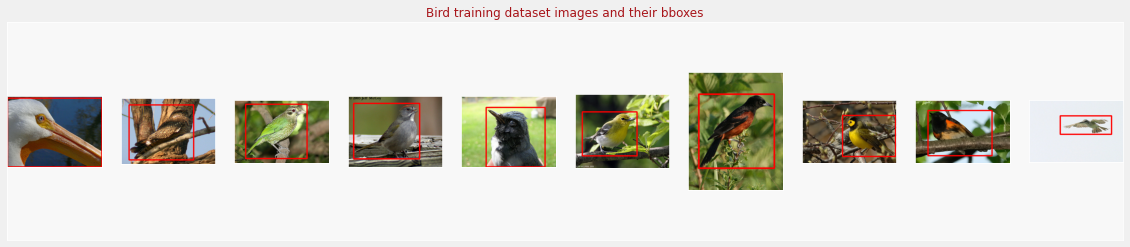

In [11]:
def get_visualization_training_dataset():
  dataset, info = tfds.load("caltech_birds2010",
                            split="train",
                            with_info=True,
                            data_dir= data_dir,
                            download=False)
  print("Info: ", info)
  visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox,
                                               num_parallel_calls=16)
  return visualization_training_dataset

visualization_training_dataset = get_visualization_training_dataset()

(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_birds_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "Bird training dataset images and their bboxes")

#### Visualizing **validation** images and their **bounding boxes**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


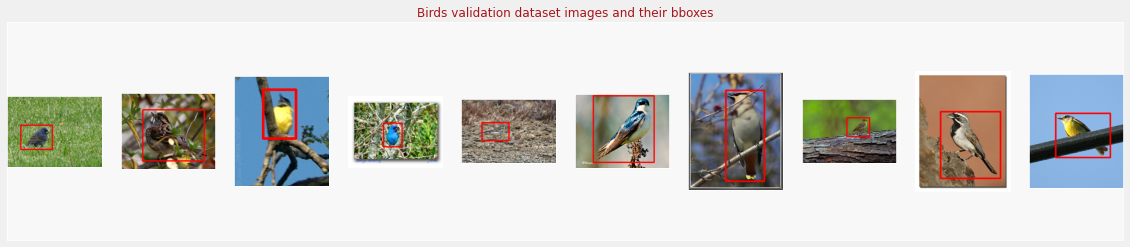

In [12]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_birds_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "Birds validation dataset images and their bboxes")

## Load & prepare the datasets for the model

These next two functions read and prepare the datasets that you'll feed to the model.
- They use `read_image_tfds` to resize, and normalize each image and its bounding box label.
- They performs shuffling and batching.
- You'll use these functions to create `training_dataset` and `validation_dataset`, which you will give to the model that you're about to build.

In [13]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

## Define the Neural Net

#### We will be using the `MobileNetV2` architecture: `Transfer Learning`

In [14]:
inputs = Input(shape=(224,224,3))
mobile_net = keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')(inputs)
x = GlobalAveragePooling2D()(mobile_net)
x = Flatten()(x)
x = Dense(1024, activation= 'relu')(x)
x = Dense(512, activation='relu')(x)
bounding_box_output = Dense(4, name="Bounding_Box_Output")(x)

model = keras.Model(inputs=inputs, outputs = bounding_box_output)

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
Bounding_Box_Output (Dense)  (None, 4)                 2052  

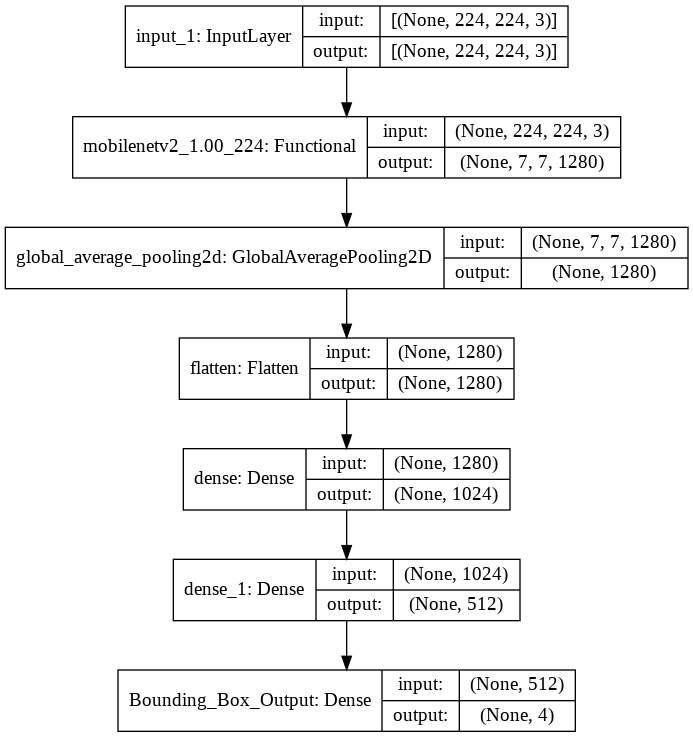

In [16]:
keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [17]:
# Compile the model

model.compile(optimizer= keras.optimizers.SGD(momentum=0.9), loss= keras.losses.mean_squared_error)

## Train the model

`steps_per_epoch:` This is the number of steps it will take to process all of the training data.  
  - If the number of training examples is not evenly divisible by the batch size, there will be one last batch that is not the full batch size.
  - Try to calculate the number steps it would take to train all the full batches plus one more batch containing the remaining training examples. `Ways to get steps_per_epoch:`
    - You can use regular division `/` and import `math` to use `math.ceil()` [Python math module docs](https://docs.python.org/3/library/math.html)
    - Alternatively, you can use `//` for integer division, `%` to check for a remainder after integer division, and an `if` statement.

In [18]:
# Training Parameters

epochs = 50

batch_size = 32
length_training_dataset = len(visualization_training_dataset)
length_validation_dataset = len(visualization_validation_dataset)

# Steps per epoch
steps_per_epoch = math.ceil(length_training_dataset/batch_size)
validation_steps = math.ceil(length_validation_dataset/batch_size)


history = model.fit(x=training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs= epochs)

Epoch 1/50
94/94 [==============================] - 106s 723ms/step - loss: 0.0585 - val_loss: 0.2596
Epoch 2/50
94/94 [==============================] - 67s 719ms/step - loss: 0.0115 - val_loss: 0.1680
Epoch 3/50
94/94 [==============================] - 67s 719ms/step - loss: 0.0077 - val_loss: 0.1148
Epoch 4/50
94/94 [==============================] - 68s 726ms/step - loss: 0.0059 - val_loss: 0.0869
Epoch 5/50
94/94 [==============================] - 68s 725ms/step - loss: 0.0048 - val_loss: 0.0670
Epoch 6/50
94/94 [==============================] - 68s 729ms/step - loss: 0.0042 - val_loss: 0.0585
Epoch 7/50
94/94 [==============================] - 67s 719ms/step - loss: 0.0037 - val_loss: 0.0446
Epoch 8/50
94/94 [==============================] - 68s 722ms/step - loss: 0.0035 - val_loss: 0.0414
Epoch 9/50
94/94 [==============================] - 69s 733ms/step - loss: 0.0031 - val_loss: 0.0368
Epoch 10/50
94/94 [==============================] - 68s 729ms/step - loss: 0.0029 - val_l

#### Methods for **step_per_epoch**

In [19]:
validation_steps = length_validation_dataset//batch_size
if length_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1
validation_steps

95

In [20]:
import math

a = math.ceil(length_validation_dataset/batch_size)
a

95

## Evaluate Model

In [21]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

95/95 [==============================] - 25s 265ms/step - loss: 0.0148
Loss:  0.014791891910135746


## Save Model

In [22]:
# Please save your model
model.save("birds.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [23]:
# Download model

from google.colab import files

files.download("birds.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot metrics

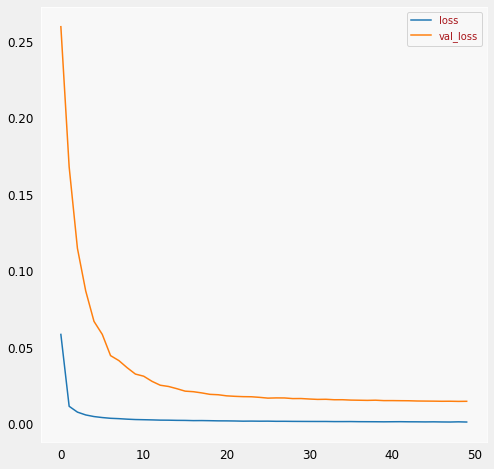

In [24]:
df = pd.DataFrame(history.history)
plt.figure(figsize=(8,8))
plt.plot(df)
plt.legend(df.columns)
plt.show()

### Evaluate using iou score

In [25]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.5): 283
Number of predictions where iou < threshold(0.5): 217


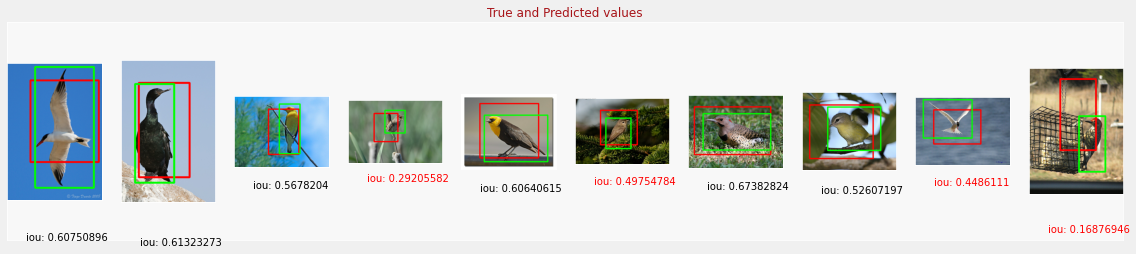

In [26]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_birds_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)